# 🧪 Laboratorio 7
Integrantes
- Diego Alexander Hernández Silvestre - 21270
- Linda Inés Jiménez Vides 21169

## 💻 Task 1

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import imageio
from IPython.display import Image, display

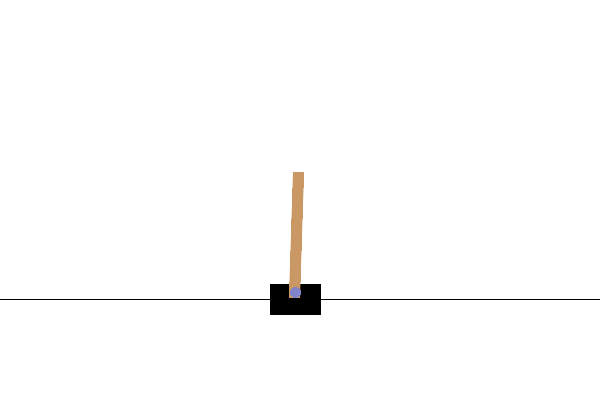

In [13]:


# Crear el entorno CartPole
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Reiniciar el entorno
state, info = env.reset()

# Lista para almacenar los frames
frames = []

# Número de pasos máximos a ejecutar
num_steps = 500

# Loop para ejecutar los pasos en el entorno
for step in range(num_steps):
    # Renderizar el entorno y capturar el frame
    frame = env.render()
    frames.append(frame)

    # Seleccionar una acción: hacia la derecha si el ángulo del poste es negativo, izquierda si es positivo
    action = 0 if state[2] < 0 else 1  # Política simple basada en el ángulo del poste
    
    # Realizar la acción en el entorno
    next_state, reward, done, truncated, info = env.step(action)
    
    # Si el episodio ha terminado, reiniciar el entorno
    if done or truncated:
        state, info = env.reset()
    else:
        state = next_state

# Cerrar el entorno
env.close()

# Guardar el GIF en un archivo
gif_filename = 'data/cartpole_simulation.gif'
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Mostrar el GIF en la celda
display(Image(filename=gif_filename))


In [6]:


env = gym.make("CartPole-v1")

def Random_games():
    # Each of this episode is its own game.
    for episode in range(10):
        env.reset()
        # this is each frame, up to 500...but we wont make it that far with random.
        for t in range(500):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            env.render()
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()

            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            next_state, reward, done, truncated, info = env.step(action)
            
            # lets print everything in one line:
            print(t, next_state, reward, done, truncated, info, action)
            if done or truncated:
                break
                
Random_games()

0 [-0.02468842 -0.18662624 -0.0065486   0.28699958] 1.0 False False {} 0
1 [-0.02842094  0.00858849 -0.00080861 -0.00774151] 1.0 False False {} 1
2 [-0.02824917  0.20372203 -0.00096344 -0.30067945] 1.0 False False {} 1
3 [-0.02417473  0.39885768 -0.00697703 -0.5936661 ] 1.0 False False {} 1
4 [-0.01619758  0.59407663 -0.01885035 -0.88853854] 1.0 False False {} 1
5 [-0.00431605  0.3992155  -0.03662112 -0.60184044] 1.0 False False {} 0
6 [ 0.00366826  0.20462441 -0.04865793 -0.32091376] 1.0 False False {} 0
7 [ 0.00776075  0.01022795 -0.05507621 -0.04396398] 1.0 False False {} 0
8 [ 0.00796531  0.20609465 -0.05595549 -0.35350275] 1.0 False False {} 1
9 [ 0.0120872   0.40196577 -0.06302554 -0.66329193] 1.0 False False {} 1
10 [ 0.02012652  0.20777462 -0.07629138 -0.3911008 ] 1.0 False False {} 0
11 [ 0.02428201  0.01381364 -0.0841134  -0.1234135 ] 1.0 False False {} 0
12 [ 0.02455829  0.21003363 -0.08658167 -0.4414031 ] 1.0 False False {} 1
13 [ 0.02875896  0.01623679 -0.09540973 -0.17721